# Generate Descriptive Statistics in Plots
Creates three plots using R's GGPlot - Words, Sentences, and Lines per day - and groups these to 'descriptives.svg'.

In [1]:
# Enable R output through IPython using RPy2
%load_ext rpy2.ipython

# SQLite3 database
import sqlite3
# NumPy: Linear algebra, random number capabilities, multi-dimensional data-container
import numpy as np
from numpy import log
# Pandas: Data structures and data analysis tools
import pandas as pd
# Datetime, Time, and Math: Date-manipulation, time- and math-related functions
from datetime import datetime, timedelta
import time, math
# Itertools: Iterators for efficient looping
from itertools import groupby
# Collections: High-performance container datatypes
from collections import defaultdict

# Set up R environment
%R require(ggplot2)
%R require(gtable)
%R require(gridExtra)
%R require(cowplot)
%R require(ggthemes)

# RPy2: Bridge between Python and R
import rpy2.rinterface as ri
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# R 'print' function, basic functionality
rprint = ro.globalenv.get("print")
base = importr('base')
stats = importr('stats')
datasets = importr('datasets')
grdevices = importr('grDevices')

# Enable inline display of images, including .png and .svg
from IPython.core.display import Image
from IPython.display import SVG, display
import uuid

# A simple function for returning an image inline in IPython after saving
grdevices = importr('grDevices')
def ggplot_notebook(gg, width = 800, height = 600):
    fn = '{uuid}.png'.format(uuid = uuid.uuid4())
    grdevices.png(fn, width = width, height = height)
    gg.plot()
    grdevices.dev_off()
    return Image(filename=fn)

In [2]:
# Read database, attach as Pandas dataframe
db = sqlite3.connect("Applications.db")
df = pd.read_sql_query("SELECT * FROM applications ORDER BY date(date) DESC", db)
db.close()

# Convert 'date' column to Datetime objects
df['date'] =  pd.to_datetime(df['date'], format="%Y-%m-%d")

# Group rows by date, calculate means
unique = pd.unique(df.date.ravel())
grouped = pd.DataFrame([{'date': k, 
    'words': v.number_words.mean(), 'sentences': v.sentences.mean(), 'lines': v.lines.mean()} 
    for k,v in df.groupby(['date'])], 
    columns=['date', 'words', 'sentences', 'lines']).sort('date', 0, 0)

# Create lists from database columns
dates = grouped['date'].tolist()
words = grouped['words'].tolist()
sentences = grouped['sentences'].tolist()
lines = grouped['lines'].tolist()

In [3]:
%R -i df print(head(df))
# Initialize and test that the Pandas DataFrame is passed to R

,ID,path,language,date,longest_sentence,shortest_sentence,lines,blanklines,sentences,number_words,...,sentence_count,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,dale_chall_readability_score,readability_consensus
0,11,data/Eng/SAGE - Ole Vik.txt,Eng,1442440800,With my administrative experience in the prepa...,I am able to relocate to London on short notice.,24,0,13,306,...,13,39.67,13.4,11.2,15.9,15.3,13.76,12.0,10.20,11th and 12th grade
1,22,data/Nor/Festspillene i Bergen - Ole Vik.txt,Nor,1442440800,I stillingen som seminarleder holdt jeg faglig...,Jeg har grundig kjennskap til Microsoft Office...,20,0,10,205,...,8,20.72,16.6,12.0,18.2,20.4,18.69,14.5,10.81,18th and 19th grade
2,25,data/Nor/FishGuard - Ole Vik.txt,Nor,1442440800,Bergen 17.09.2015 Fishguard 5035 Bergen Søknad...,"Jeg håper på positiv tilbakemelding, og møter ...",16,0,9,160,...,7,32.22,14.2,10.8,17.1,18.9,18.63,14.0,10.85,18th and 19th grade
3,36,data/Nor/Kanalbruket - Ole Vik.txt,Nor,1442440800,Bergen 17.09.2015 Kanalbruket 3251 Larvik Søkn...,"Jeg håper på positiv tilbakemelding, og møter ...",14,0,8,142,...,6,31.21,14.6,11.2,17.1,18.9,18.16,14.5,10.89,14th and 15th grade
4,8,data/Eng/Norwegian Barents Secretariat - Ole V...,Eng,1442354400,With my administrative experience in the prepa...,The thesis was graded as Exceptional; grade tr...,21,0,10,254,...,10,29.18,15.4,12.0,17.1,17.4,15.15,14.0,10.72,17th and 18th grade
5,1,data/Eng/AcademicMinds - Ole Vik.txt,Eng,1442268000,With my administrative experience in the prepa...,My master’s thesis was graded as Exceptional; ...,21,0,10,247,...,10,38.66,13.8,11.6,15.9,16.8,14.86,12.0,10.39,11th and 12th grade


In [4]:
%%R
# Initialize R and define variables
pointsize <- 3 # Define a pointsize for use in scatter plots
colour_cutoff <- 5 # Define a default cutoff for colour scales

In [5]:
%%R
# Initialize R and plot Words per day
blackwhite = FALSE
wordplot <- ggplot(data = df, aes
                    (x = date, 
                    y = number_words, 
                    colour = cut(number_words, colour_cutoff))) +
    geom_point(size = pointsize) +
    stat_smooth(aes(group = 1), method = "lm", size = 1, color = "grey50", alpha = 0.1) +
    labs(y = "Words") +
    ggtitle("Words, Sentences, and Lines per day") +
    theme(axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.title.x=element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          legend.position="none",
          plot.title = element_text(size = rel(1.5), vjust=3),
          plot.margin = unit(c(1,0.5,0,0.5), "cm"),
          axis.title.y=element_text(vjust=1.5))
if (blackwhite) {
    wordplot = wordplot + scale_colour_grey()
} else {
    wordplot = wordplot + scale_colour_brewer(type = "div", palette = 5)
}
#ggsave(file = "wordplot.svg", path = "Plots", plot = wordplot, width = 10, height = 8, dpi = 100)

In [6]:
%%R
# Initialize R and plot Sentences per day
blackwhite = FALSE
sentenceplot <- ggplot(data = df, aes(
                        x = date, 
                        y = sentences, 
                        colour = cut(sentences, colour_cutoff))) +
    geom_point(size = pointsize) +
    stat_smooth(aes(group = 1), method = "lm", size = 1, color = "grey50", alpha = 0.1) +
    labs(y = "Sentences") +
    theme(axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.title.x=element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          legend.position="none",
          plot.margin = unit(c(0,0.5,0,0.5), "cm"),
          axis.title.y=element_text(vjust=1.5))
if (blackwhite) {
    sentenceplot = sentenceplot + scale_colour_grey()
} else {
    sentenceplot = sentenceplot + scale_colour_brewer(type = "div", palette = 5)
}
#ggsave(file = "sentenceplot.svg", path = "Plots", plot = sentenceplot, width = 10, height = 8, dpi = 100)

In [7]:
%%R
# Initialize R and plot Lines per day
blackwhite = FALSE
lineplot <- ggplot(data = df, aes(
                    x = date, 
                    y = lines, 
                    colour = cut(lines, colour_cutoff))) +
    geom_point(size = pointsize) +
    stat_smooth(aes(group = 1), method = "lm", size = 1, color = "grey50", alpha = 0.1) +
    labs(x = "", y = "Lines") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.position="none",
          plot.margin = unit(c(0,0.5,0.5,0.5), "cm"),
          axis.title.y=element_text(vjust=1.5))
if (blackwhite) {
    lineplot = lineplot + scale_colour_grey()
} else {
    lineplot = lineplot + scale_colour_brewer(type = "div", palette = 5)
}
#ggsave(file = "lineplot.svg", path = "Plots", plot = lineplot, width = 10, height = 8, dpi = 100)

In [8]:
%%R
# Group the figures using cowplot plot.grid()
descriptives <- plot_grid(
    wordplot, sentenceplot, lineplot,
    label_size = 12,
    ncol = 1, 
    align = "v")
ggsave(file = "descriptives.svg", path = "Plots", plot = descriptives, width = 10, height = 8, dpi = 100)

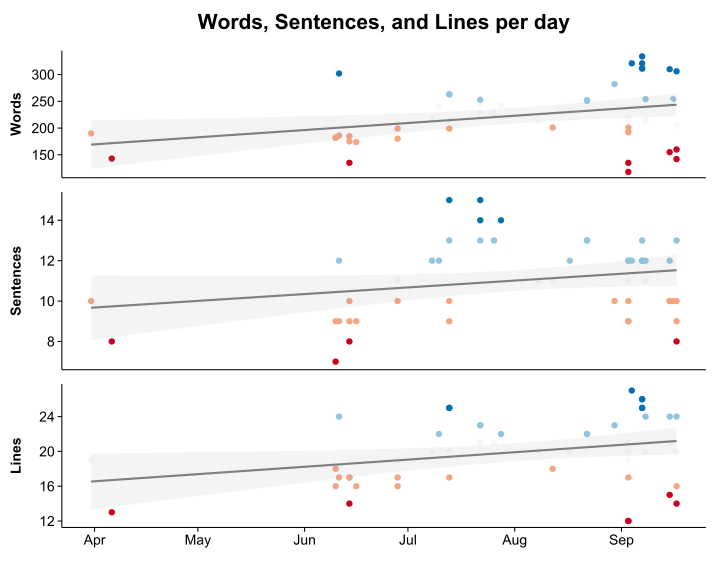

In [9]:
# Display the complete Descriptives plot
display(SVG(filename='Plots/descriptives.svg'))